# Install Required Libraries

In [1]:
pip install tensorflow scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


# Data Preprocessing

In [2]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
data_file_path = 'Documents/diabetes2.csv'
data_new = pd.read_csv(data_file_path)

# Encode categorical variables (gender and diabetic columns)
#label_encoder = LabelEncoder()
#data_new['gender'] = label_encoder.fit_transform(data_new['gender'])
#data_new['smoking_history'] = label_encoder.fit_transform(data_new['smoking_history'])

# Features and target variable
X = data_new.drop(columns=['Outcome'])
y = data_new['Outcome']

# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape the data for RNN (samples, time steps, features)
X_scaled = np.expand_dims(X_scaled, axis=1)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Display the shapes of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (614, 1, 8)
X_test shape: (154, 1, 8)
y_train shape: (614,)
y_test shape: (154,)


# Build the RNN Model (LSTM with Dropout)

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Function to create the RNN model with LSTM and Dropout
def create_model(lstm_units=64, dropout_rate=0.2):
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu', return_sequences=True))
    model.add(Dropout(dropout_rate))  # Add dropout for regularization
    model.add(LSTM(lstm_units//2, activation='relu'))
    model.add(Dropout(dropout_rate))  # Add dropout for regularization
    model.add(Dense(1, activation='sigmoid'))  # Output layer for binary classification
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model for use with scikit-learn
model = KerasClassifier(build_fn=create_model, verbose=0)

# Check the summary of the model (for debugging)
model_instance = create_model(lstm_units=64, dropout_rate=0.2)
model_instance.summary()

C:\Users\Asus\AppData\Local\Temp\ipykernel_12564\2348622470.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_model, verbose=0)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             18688     
                                                                 
 dropout (Dropout)           (None, 1, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 31,137
Trainable params: 31,137
Non-trainable params: 0
_________________________________________________________________


# Hyperparameter Tuning with GridSearchCV

In [4]:
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [10, 50],
    'lstm_units': [64, 128, 256],
    'dropout_rate': [0.2, 0.3]
}

# Use GridSearchCV for hyperparameter tuning
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2)
grid_result = grid.fit(X_train, y_train)

# Print the best parameters and results
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, lstm_units=64; total time=   6.9s
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, lstm_units=64; total time=   5.9s
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, lstm_units=64; total time=   5.9s
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, lstm_units=128; total time=   6.9s
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, lstm_units=128; total time=   6.5s
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, lstm_units=128; total time=   8.0s
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, lstm_units=256; total time=   6.5s
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, lstm_units=256; total time=   7.3s
[CV] END batch_size=16, dropout_rate=0.2, epochs=10, lstm_units=256; total time=   7.9s
[CV] END batch_size=16, dropout_rate=0.2, epochs=50, lstm_units=64; total time=  12.4s
[CV] END batch_size=16, dropout_rate=0.2, epochs=50, lstm_unit

# Evaluate the Model

5/5 [==============================] - 0s 3ms/step
ROC AUC Score: 0.7404040404040404
Confusion Matrix:
[[80 19]
 [18 37]]
Precision: 0.6607142857142857
Recall: 0.6727272727272727
F1 Score: 0.6666666666666666


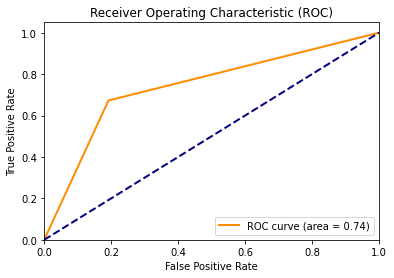

In [5]:
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Predict on the test set
y_pred = grid.best_estimator_.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

# Calculate metrics

roc_auc = roc_auc_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print metrics
print(f"ROC AUC Score: {roc_auc}")
print(f"Confusion Matrix:\n{cm}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

# Cross-Validation with Stratified K-Fold

In [6]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

# Use Stratified K-Fold Cross-Validation for better performance evaluation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluate using cross-validation
results = cross_val_score(grid.best_estimator_, X_scaled, y, cv=kfold)
print(f"Cross-validated Accuracy: {results.mean()}")

Cross-validated Accuracy: 0.7746965408325195


# Optional - Early Stopping and Learning Rate Scheduler

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

# Re-train the model with callbacks (optional)
history = grid.best_estimator_.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, 
                                   callbacks=[early_stopping, lr_scheduler])


Epoch 13: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
